参考文档教程：

https://langchain-ai.github.io/langgraph/tutorials/get-started/3-add-memory/


In [ ]:
# https://python.langchain.com/docs/integrations/tools/tavily_search/

# 获取密钥的地址： https://app.tavily.com/sign-in




import os
TAVILY_API_KEY="tvly-dev-123"
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY


In [10]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=5)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")


{'query': "What's a 'node' in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': "Mastering LangGraph: A Beginner's Guide to Building ... - Medium",
   'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
   'content': 'Stateful Graph: LangGraph revolves around the concept of a stateful graph, where each node in the graph represents a step in your computation, and the graph maintains a state that is passed around and updated as the computation progresses. LangGraph supports conditional edges, allowing you to dynamically determine the next node to execute based on the current state of the graph. We define nodes for classifying the input, handling greetings, and handling search queries. def classify_input_node(state): LangGraph is a versatile tool for building complex, stateful applications with LLMs. By understanding its core concepts and working through simple examples, beginners can start to leverag

In [11]:
import os
from langchain.chat_models import init_chat_model

API_KEY = "sk-123"

BASE_URL = "https://api.deepseek.com"

os.environ["OPENAI_API_KEY"] = API_KEY
os.environ["OPENAI_API_BASE"] = BASE_URL


llm = init_chat_model("openai:deepseek-chat")

In [12]:
#我们现在可以将它合并到 ：StateGraph

from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# Modification: tell the LLM which tools it can call
# highlight-next-line
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

In [ ]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearch(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

In [14]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [15]:
graph = graph_builder.compile(checkpointer=memory)

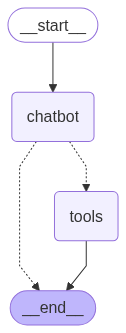

In [16]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [17]:
#与您的聊天机器人互动


config = {"configurable": {"thread_id": "1"}}


user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()
    

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hi Will! Nice to meet you. How can I assist you today?


In [18]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Of course, Will! I’ll remember your name for the rest of our conversation. How can I help you today?


In [19]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I don’t have the ability to remember personal information between interactions. However, you can tell me your name, and I’ll happily use it in our current conversation! What should I call you?


In [ ]:
# 使用上一个会话的内存，测试，是否支持多轮对话
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "1"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Got it, Will! I’ll keep your name in mind while we chat. What can I do for you? 😊


In [21]:
# 5. 检查状态

snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='daa419e4-9fad-4c1f-bc48-5636cc15c0b6'), AIMessage(content='Hi Will! Nice to meet you. How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 1246, 'total_tokens': 1261, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 1216}, 'prompt_cache_hit_tokens': 1216, 'prompt_cache_miss_tokens': 30}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_8802369eaa_prod0425fp8', 'id': '1ff30ffe-4560-4795-8c81-0d91cbafc872', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--5393b367-8a4c-42dd-9d9b-d07063b7c0fd-0', usage_metadata={'input_tokens': 1246, 'output_tokens': 15, 'total_tokens': 1261, 'input_token_details': {'cache_read': 1216}, 'output_token_details': {}}), HumanMessage(content='Remember my n

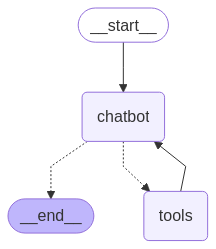

User: 我叫 aixiaoxin
Assistant: 你好，aixiaoxin！有什么可以帮你的吗？ 😊
User: 我叫什么
Assistant: 你刚才告诉我你叫 **aixiaoxin**！需要我帮你做什么吗？ 😊
User: 你叫什么
Assistant: 我是你的智能助手，你可以叫我 **小助手** 或 **助手**！如果你有其他喜欢的名字，也可以告诉我，我会很乐意接受的！ 😊
User: 你会做什么
Assistant: 我可以做很多事情！以下是一些我能帮助你的方面：

### 1. **信息查询**
   - 回答各种知识性问题，比如历史、科学、技术、文化等。
   - 提供最新的新闻、天气、股票行情等实时信息。

### 2. **学习辅导**
   - 解答数学、物理、化学等学科问题。
   - 帮助写作、翻译、修改文章或提供写作灵感。

### 3. **日常生活**
   - 推荐美食、旅游景点、电影、书籍等。
   - 提供健康、健身、心理等方面的建议。

### 4. **技术支持**
   - 解释编程问题，帮助调试代码。
   - 提供软件、硬件相关的建议或教程。

### 5. **娱乐互动**
   - 讲笑话、故事，或者陪你聊天。
   - 生成诗歌、歌词、短篇小说等创意内容。

### 6. **工具辅助**
   - 单位换算、日期计算、货币转换等。
   - 生成待办事项、提醒事项或简单的计划。

### 7. **个性化服务**
   - 根据你的喜好推荐内容。
   - 记住你的偏好，提供更贴心的服务。

如果你有任何具体的需求，随时告诉我，我会尽力帮你完成！ 😊
User: 你会调用哪些工具
Assistant: 目前，我可以调用以下工具来帮助你完成任务：

### 1. **Tavily 搜索引擎**
   - **功能**：提供全面的网络搜索功能，适合查找最新的新闻、知识、技术资料等。
   - **用途**：
     - 回答实时性问题（如新闻、事件）。
     - 查找特定领域的资料（如学术论文、产品评测）。
     - 支持高级搜索选项（如限定域名、时间范围）。

### 2. **自定义函数**
   - 根据你的需求，我还可以通过编程或调用其他 API 来完成特定任务，比如：
     - 数

: 

In [ ]:
# 完整的demo示例


from typing import Annotated

from langchain.chat_models import init_chat_model
from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearch(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
memory = MemorySaver()



graph = graph_builder.compile(checkpointer=memory)


config = {"configurable": {"thread_id": "1"}}



from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


#8. 向机器人提问
def stream_graph_updates(user_input: str):
    for event in graph.stream(
        {"messages": [{"role": "user", "content": user_input}]},
        config
        ):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        print("User: " + user_input)
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

